## Project: Buid a Knowledge Graph 

### Web scraping

The first step to build a Knowledge Graphs is collecting data from resources. Typically, people usually crawl data from web. One of the most useful resources is Wikipadia. Wikipedia will be our source (always check the sources of data, a lot of information online is false).

In this step, we use Wikipedia API, a direct Python wrapper to collect the necessary data.

In [ ]:
# Install dependencies and scrape data
%pip install wikipedia-api pandas spacy networkx scipy

In [1]:
import wikipediaapi  # pip install wikipedia-api
import pandas as pd
import concurrent.futures
from tqdm import tqdm

In [2]:
def scrape_wikipedia(name_topic, verbose=True):
   def link_to_wikipedia(link):
       try:
           page = api_wikipedia.page(link)
           if page.exists():
               return {'page': link, 'text': page.text, 'link': page.fullurl, 'categories': list(page.categories.keys())}
       except:
           return None
      
   api_wikipedia = wikipediaapi.Wikipedia(language='en', extract_format=wikipediaapi.ExtractFormat.WIKI)
   name_of_page = api_wikipedia.page(name_topic)
   if not name_of_page.exists():
       print('Page {} is not present'.format(name_of_page))
       return
  
   links_to_page = list(name_of_page.links.keys())
   procceed = tqdm(desc='Scraped links', unit='', total=len(links_to_page)) if verbose else None
   origin = [{'page': name_topic, 'text': name_of_page.text, 'link': name_of_page.fullurl, 'categories': list(name_of_page.categories.keys())}]
  
   with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
       links_future = {executor.submit(link_to_wikipedia, link): link for link in links_to_page}
       for future in concurrent.futures.as_completed(links_future):
           info = future.result()
           origin.append(info) if info else None
           procceed.update(1) if verbose else None
   procceed.close() if verbose else None
  
   namespaces = ('Wikipedia', 'Special', 'Talk', 'LyricWiki', 'File', 'MediaWiki', 'Template', 'Help', 'User', 'Category talk', 'Portal talk')
   origin = pd.DataFrame(origin)
   origin = origin[(len(origin['text']) > 20) & ~(origin['page'].str.startswith(namespaces, na=True))]
   origin['categories'] = origin.categories.apply(lambda a: [b[9:] for b in a])

   origin['topic'] = name_topic
   print('Scraped pages', len(origin))
  
   return origin

In [3]:
wiki_data_covid = scrape_wikipedia('COVID 19')

Scraped links: 100%|██████████| 2241/2241 [09:08<00:00,  4.08/s]

Scraped pages 2034


In [4]:
wiki_data_covid.to_csv('scraped_covid_data.csv')

In [2]:
import spacy
import pandas as pd
import requests
from spacy import displacy

nlp = spacy.load('en_core_web_sm')
 
from spacy.tokens import Span
from spacy.matcher import Matcher
 
import matplotlib.pyplot as plot
from tqdm import tqdm
import networkx as ntx
%matplotlib inline

In [7]:
data = pd.read_csv('scraped_covid_data.csv')
data.head(5)

,Unnamed: 0,page,text,link,categories,topic
0,0,COVID 19,Coronavirus disease 2019 (COVID-19) is a conta...,https://en.wikipedia.org/wiki/COVID-19,"['All Wikipedia articles in need of updating',...",COVID 19
1,1,202-CoV,202-CoV is a COVID-19 vaccine candidate develo...,https://en.wikipedia.org/wiki/202-CoV,"['All stub articles', 'Articles containing unv...",COVID 19
2,2,2020 Tablighi Jamaat COVID-19 hotspot in Malaysia,A Tablighi Jamaat religious conference that to...,https://en.wikipedia.org/wiki/2020_Tablighi_Ja...,"['2020s in Malaysia', 'Articles with short des...",COVID 19
3,3,2020 Russia–Saudi Arabia oil price war,"On 8 March 2020, Saudi Arabia initiated a pric...",https://en.wikipedia.org/wiki/2020_Russia%E2%8...,"['2020 in Russia', '2020 in Saudi Arabia', '20...",COVID 19
4,4,2020 Tablighi Jamaat COVID-19 hotspot in Delhi,A Tablighi Jamaat religious congregation that ...,https://en.wikipedia.org/wiki/2020_Tablighi_Ja...,"['2020s in Delhi', 'All Wikipedia articles wri...",COVID 19


### Sentence segmentation

In [8]:
docu = nlp(data['text'][10])
for tokn in docu:
   print(tokn.text, "---", tokn.dep_)

The --- det
2020 --- nummod
– --- punct
present --- amod
global --- amod
chip --- compound
shortage --- nsubj
is --- ROOT
an --- det
ongoing --- amod
crisis --- attr
in --- prep
which --- pobj
the --- det
demand --- nsubj
for --- prep
integrated --- amod
circuits --- pobj
( --- punct
commonly --- advmod
known --- acl
as --- prep
semiconductor --- compound
chips --- pobj
) --- punct
is --- relcl
greater --- acomp
than --- prep
the --- det
supply --- pobj
, --- punct
affecting --- advcl
more --- amod
than --- quantmod
169 --- nummod
industries --- dobj
and --- cc
has --- aux
led --- conj
to --- prep
major --- amod
price --- compound
increases --- pobj
, --- punct
shortages --- conj
and --- cc
queues --- conj
amongst --- prep
consumers --- pobj
for --- prep
automobiles --- pobj
, --- punct
graphics --- compound
cards --- conj
, --- punct
video --- compound
game --- compound
consoles --- conj
, --- punct
computers --- conj
, --- punct
and --- cc
other --- amod
products --- conj
that --- ns

### Entity extraction

In [9]:
def extract_entities(sents):
   # chunk one
   enti_one = ""
   enti_two = ""
  
   dep_prev_token = "" # dependency tag of previous token in sentence
  
   txt_prev_token = "" # previous token in sentence
  
   prefix = ""
   modifier = ""
  
   for tokn in nlp(sents):
       # chunk two
       ## move to next token if token is punctuation
      
       if tokn.dep_ != "punct":
           #  check if token is compound word or not
           if tokn.dep_ == "compound":
               prefix = tokn.text
               # add the current word to it if the previous word is 'compound’
               if dep_prev_token == "compound":
                   prefix = txt_prev_token + " "+ tokn.text
                  
           # verify if token is modifier or not
           if tokn.dep_.endswith("mod") == True:
               modifier = tokn.text
               # add it to the current word if the previous word is 'compound'
               if dep_prev_token == "compound":
                   modifier = txt_prev_token + " "+ tokn.text
                  
           # chunk3
           if tokn.dep_.find("subj") == True:
               enti_one = modifier +" "+ prefix + " "+ tokn.text
               prefix = ""
               modifier = ""
               dep_prev_token = ""
               txt_prev_token = ""
              
           # chunk4
           if tokn.dep_.find("obj") == True:
               enti_two = modifier +" "+ prefix +" "+ tokn.text
              
           # chunk 5
           # update variable
           dep_prev_token = tokn.dep_
           txt_prev_token = tokn.text
          
   return [enti_one.strip(), enti_two.strip()]

In [10]:
extract_entities(data['text'][10])

['References', 'therefore  cars']

In [11]:
pairs_of_entities = []
for i in tqdm(data['text'][:800]):
   pairs_of_entities.append(extract_entities(i))

100%|██████████| 800/800 [06:34<00:00,  2.03it/s]


In [12]:
pairs_of_entities[36:42]

[['External International Retrovirology links', 'human virus type I'],
 ['USAMRMC', 'macromolecular EM Data Month'],
 ['Aerosols Global |', 'Research Assembly aerosol sampling'],
 ['External  links', 'Official  website'],
 ['2005 Massachusetts Eye', 'specific  tastes'],
 ['original Sina text', 'Whistle Giver']]

### Relations extraction

In [21]:
def obtain_relation(sent):
  
   doc = nlp(sent)
  
   matcher = Matcher(nlp.vocab)
  
   pattern = [[{'DEP':'ROOT'},
           {'DEP':'prep','OP':"?"},
           {'DEP':'agent','OP':"?"}, 
           {'POS':'ADJ','OP':"?"}]]
  
   #matcher.add("matching_1", None, pattern)
   matcher.add('matching_1', pattern)
  
   matcher = matcher(doc)
   h = len(matcher) - 1
  
   span = doc[matcher[h][1]:matcher[h][2]]
  
   return (span.text)

In [23]:
relations = [obtain_relation(j) for j in (data['text'][:800])]

In [24]:
pd.Series(relations).value_counts()[:50]

=                    363
See                   90
see                   18
Retrieved             11
announced              6
is                     6
confirmed              6
PMID                   5
Library of             5
COVID-19               4
reading                4
ISBN                   3
Guidance for post      3
canceled               3
retrieved              3
updates                3
CSSE                   3
Note                   3
saw                    2
news                   2
include                2
found                  2
August                 2
Page                   2
Agency                 2
July                   2
News                   2
protects               2
map                    2
CoronaTracker          2
began                  2
Covid-19               2
enzyme                 2
reports on             2
May                    2
site                   2
wave                   2
Available in           2
S2CID                  2
cases                  2


### Build a Knowledge Graph

In [25]:
# subject extraction
source = [j[0] for j in pairs_of_entities]

#object extraction
target = [k[1] for k in pairs_of_entities]

data_kgf = pd.DataFrame({'source':source, 'edge':relations, 'target':target})

In [27]:
data_kgf.to_csv('graph.csv', index=False)

In [28]:
# Create DG from the dataframe
graph = ntx.from_pandas_edgelist(data_kgf, "source", "target",
                         edge_attr=True, create_using=ntx.MultiDiGraph())

 10%|▉         | 78/800 [11:05<1:42:42,  8.53s/it]
/home/lnnam/anaconda3/envs/python38/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2837 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lnnam/anaconda3/envs/python38/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2891 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lnnam/anaconda3/envs/python38/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2861 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lnnam/anaconda3/envs/python38/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2879 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lnnam/anaconda3/envs/python38/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2849 missing from current font.
  font.set_

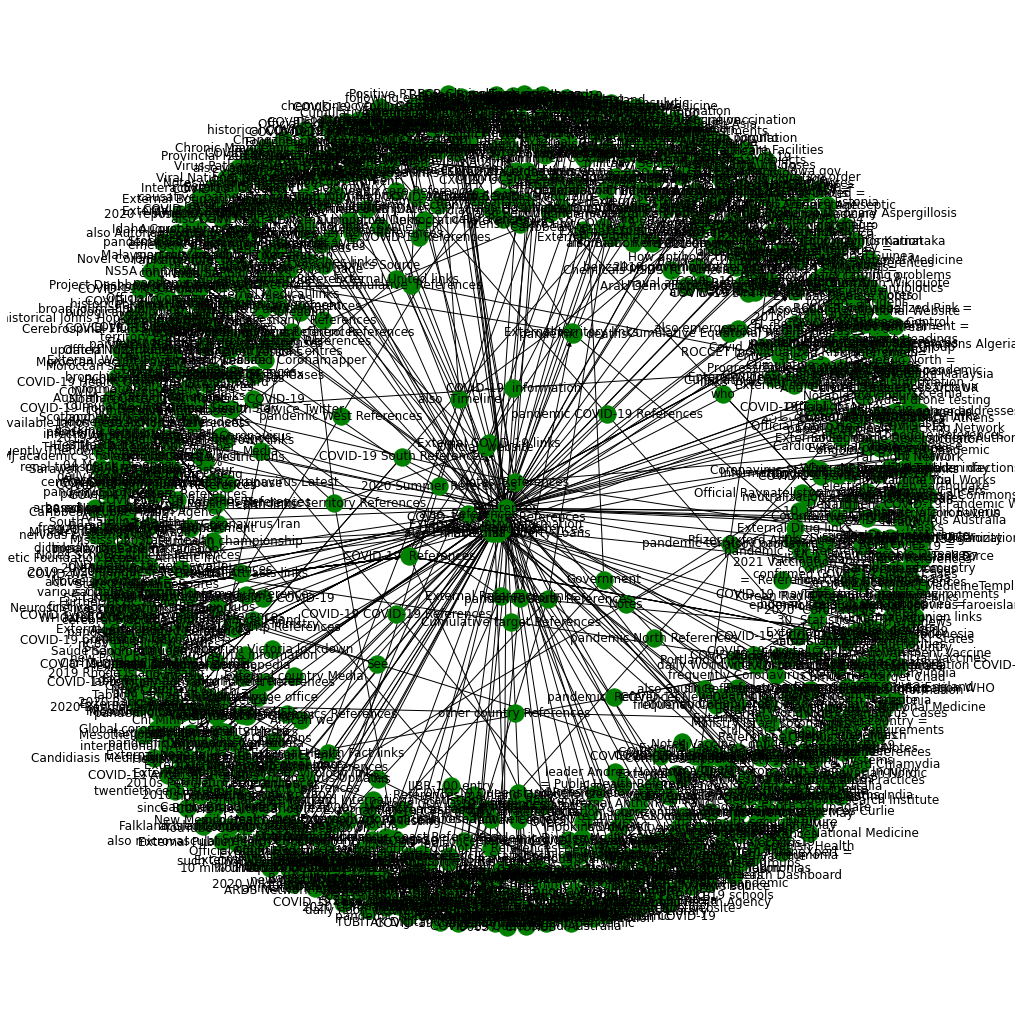

In [29]:
# plotting the network
plot.figure(figsize=(14, 14))
posn = ntx.spring_layout(graph)
ntx.draw(graph, with_labels=True, node_color='green', edge_cmap=plot.cm.Blues, pos = posn)
plot.show()

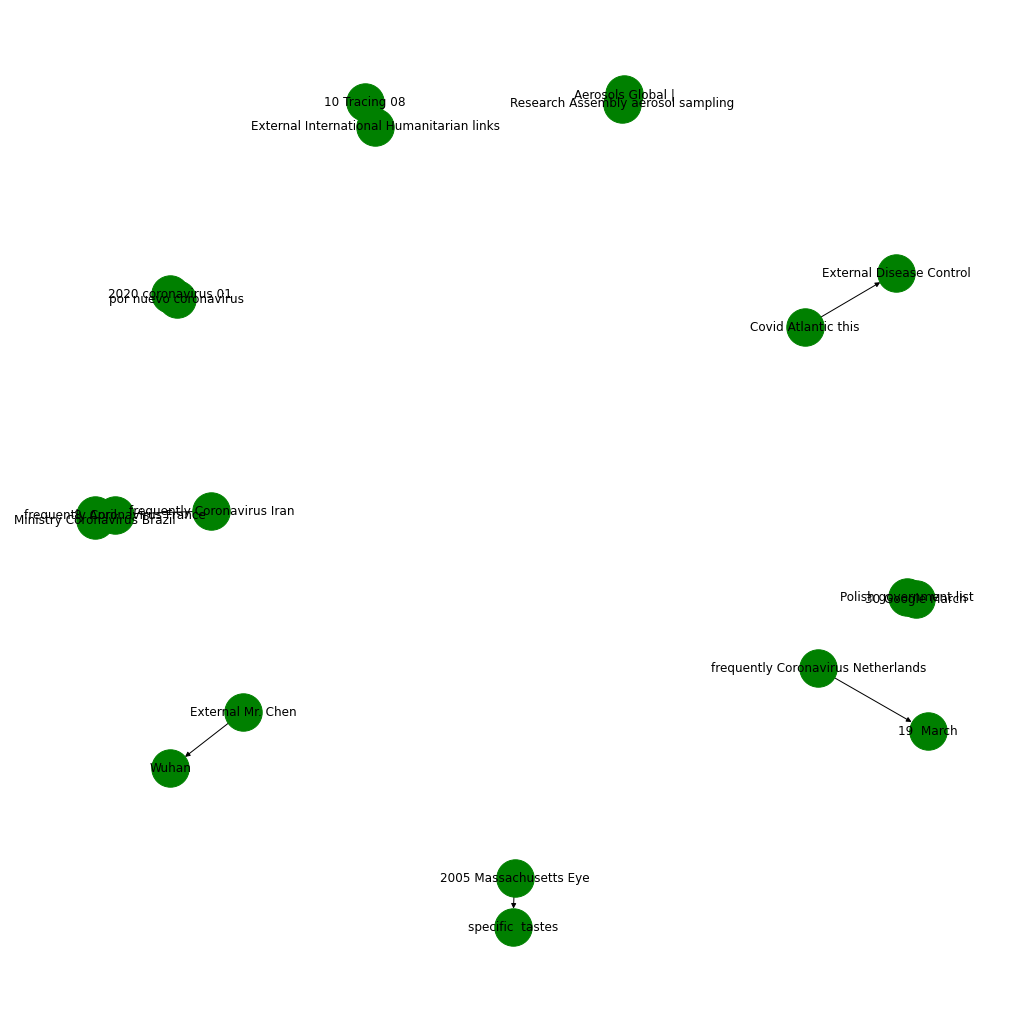

In [31]:
graph = ntx.from_pandas_edgelist(data_kgf[data_kgf['edge']=="Retrieved"], "source", "target",
                         edge_attr=True, create_using=ntx.MultiDiGraph())
 
plot.figure(figsize=(14,14))
pos = ntx.spring_layout(graph, k = 0.5) # k regulates the distance between nodes
ntx.draw(graph, with_labels=True, node_color='green', node_size=1400, edge_cmap=plot.cm.Blues, pos = posn)
plot.show()

In [3]:
graph = pd.read_csv('graph.csv', sep=',', names=['from', 'to', 'rel'])
graph.head()

,from,to,rel
0,source,edge,target
1,WHO/2019 nCoV NHS England,Guidance for post,COVID syndrome assessment clinics
2,References,=,COVID-19 Zerun Biotechnology Co.
3,COVID-19 Tablighi Notes,=,COVID-19 Tablighi Malaysia
4,2010s Petroleum References,=,2010s Petroleum =


In [38]:
%pip install torchkge==0.16.25 -q

Note: you may need to restart the kernel to use updated packages.


In [16]:
import torch
from torch import nn
from torch import cuda
import torch.nn.functional as F
from torch.nn.init import xavier_uniform_

from torchkge import KnowledgeGraph
from torchkge.evaluation import LinkPredictionEvaluator
from torchkge.models.interfaces import TranslationModel
from torchkge.sampling import BernoulliNegativeSampler
from torchkge.utils import MarginLoss, DataLoader

In [5]:
kg = KnowledgeGraph(graph)

In [11]:
kg_train, kg_test = kg.split_kg()

In [6]:
# Define some hyper-parameters for training
emb_dim = 100
lr = 0.0004
n_epochs = 1000
b_size = 32768
margin = 0.5

In [7]:
class BaseTransE(TranslationModel):
    def __init__(self, num_entities, num_relations, dim=100):
        super(BaseTransE, self).__init__(num_entities, num_relations, dissimilarity_type='L2')
        self.num_entities = num_entities
        self.num_relations = num_relations
        self.dim = dim

        self.ent_embeddings = nn.Embedding(num_entities, self.dim)
        self.rel_embeddings = nn.Embedding(num_relations, self.dim)
        
        xavier_uniform_(self.ent_embeddings.weight.data)
        xavier_uniform_(self.rel_embeddings.weight.data)

        self.normalize_parameters()
        self.rel_embeddings.weight.data = F.normalize(self.rel_embeddings.weight.data, p=2, dim=1)

    def normalize_parameters(self):
        self.ent_embeddings.weight.data = F.normalize(self.ent_embeddings.weight.data, p=2, dim=1)

    def get_embeddings(self):
        self.normalize_parameters()
        return self.ent_embeddings.weight.data, self.rel_embeddings.weight.data
        
    def lp_prep_cands(self, h_idx, t_idx, r_idx):
        b_size = h_idx.shape[0]

        h_emb = self.ent_embeddings(h_idx)
        t_emb = self.ent_embeddings(t_idx)
        r_emb = self.rel_embeddings(r_idx)

        candidates = self.ent_embeddings.weight.data.view(1, self.num_entities, self.dim)
        candidates = candidates.expand(b_size, self.num_entities, self.dim)

        return h_emb, t_emb, candidates, r_emb
    
    def forward(self, h, t, nh, nt, r):
        return self.scoring_function(h, t, r), self.scoring_function(nh, nt, r)

    @staticmethod
    def l2_dissimilarity(a, b):
        assert len(a.shape) == len(b.shape)
        return (a-b).norm(p=2, dim=-1)**2

    @staticmethod
    def l1_dissimilarity(a, b):
        assert len(a.shape) == len(b.shape)
        return (a-b).norm(p=1, dim=-1)

In [8]:
class TransE(BaseTransE):
    def scoring_function(self, h, t, r):
        h = F.normalize(self.ent_embeddings(h), p=2, dim=1)
        t = F.normalize(self.ent_embeddings(t), p=2, dim=1)
        r = self.rel_embeddings(r)
        scores = -torch.norm(h + r - t, 2, -1)
        return scores

In [9]:
class MarginLoss(nn.Module):
    def __init__(self, margin):
        super().__init__()
        self.margin = margin
        self.loss = nn.MarginRankingLoss(margin=margin, reduction='mean')
    def forward(self, positive_scores, negative_scores):
        return self.loss(positive_scores, negative_scores, target=torch.ones_like(positive_scores))

In [15]:
# Define model
model = TransE(kg_train.n_ent, kg_train.n_rel, dim=64)

# Define criterion for training model
criterion = MarginLoss(margin=0.5)

In [18]:
# Move everything to CUDA if available
if cuda.is_available():
    cuda.empty_cache()
    model.cuda()
    criterion.cuda()

In [19]:
# Define the torch optimizer to be used
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

# Define negative sampler
sampler = BernoulliNegativeSampler(kg_train)

# Define Dataloader
dataloader = DataLoader(kg_train, batch_size=b_size, use_cuda='all')

# Training loop
iterator = tqdm(range(n_epochs), unit='epoch')
for epoch in iterator:
    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        h, t, r = batch[0], batch[1], batch[2]
        n_h, n_t = sampler.corrupt_batch(h, t, r)

        optimizer.zero_grad()

        # forward + backward + optimize
        pos, neg = model(h, t, n_h, n_t, r)
        loss = criterion(pos, neg)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    iterator.set_description(
        'Epoch {} | mean loss: {:.5f}'.format(epoch + 1, running_loss / len(dataloader)))

model.normalize_parameters()

Epoch 1000 | mean loss: 0.00178: 100%|██████████| 1000/1000 [00:03<00:00, 266.76epoch/s]


In [20]:
# Define evaluator
evaluator = LinkPredictionEvaluator(model, kg_test)

# Run evaluator
evaluator.evaluate(b_size=128)

Link prediction evaluation: 100%|██████████| 1/1 [00:00<00:00, 72.16batch/s]


In [23]:
# Show results
print("----------------Overall Results----------------")
print('Hit@10: {:.4f}'.format(evaluator.hit_at_k(k=10)[0]))
print('Hit@3: {:.4f}'.format(evaluator.hit_at_k(k=3)[0]))
print('Hit@1: {:.4f}'.format(evaluator.hit_at_k(k=1)[0]))
print('Mean Rank: {:.4f}'.format(evaluator.mean_rank()[0]))
print('Mean Reciprocal Rank : {:.4f}'.format(evaluator.mrr()[0]))

----------------Overall Results----------------
Hit@10: 0.9767
Hit@3: 0.9419
Hit@1: 0.8372
Mean Rank: 2.6977
Mean Reciprocal Rank : 0.8905
